# Chapter 9 Elliptic PDEs with random data

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy
from scipy import sparse
from scipy.sparse import linalg
from mpl_toolkits.mplot3d import Axes3D

First we need to code for FEM.

Fig 2.7


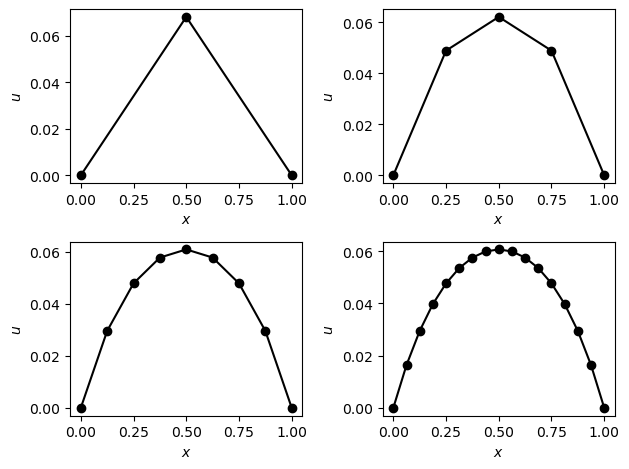

In [ ]:
def Get_Ele_Info(h, p, q, f, ne):
    Kks=np.zeros((ne,2,2));    
    Kks[:,0,0]=p/h; Kks[:,0,1]=-p/h; Kks[:,1,0]=-p/h; Kks[:,1,1]=p/h;
    Mks=np.zeros_like(Kks)
    Mks[:,0,0]=q*h/3; Mks[:,0,1]=q*h/6; Mks[:,1,0]=q*h/6; Mks[:,1,1]=q*h/3
    bks=np.zeros((ne,2))
    bks[:,0]=f*(h / 2); bks[:,1]=f*(h / 2)
    return Kks, Mks, bks


def FEM_Solver1D_r1(ne, p, q, f):
    h = 1 / ne
    x = np.linspace(0, 1, ne + 1)
    nvtx = ne + 1
    Kks,Mks,bks=Get_Ele_Info(h,p,q,f,ne)
    elt2vert=np.vstack((np.arange(0, nvtx - 1, dtype='int'),
                        np.arange(1, nvtx, dtype='int')))
    b = np.zeros(nvtx)
    K = sum(sparse.csc_matrix((Kks[:,row_no,col_no],(elt2vert[row_no,:],elt2vert[col_no,:])),
                               (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    M = sum(sparse.csc_matrix((Mks[:,row_no,col_no],(elt2vert[row_no,:],elt2vert[col_no,:])),
                               (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    for row_no in range(2):
        nrow=elt2vert[row_no,:]
        b[nrow]=b[nrow]+bks[:,row_no]
    A=K + M
    # impose homogeneous boundary condition
    A=A[1:-1,1:-1]; K=K[1:-1,1:-1]; M=M[1:-1,1:-1]
    b=b[1:-1]
    # solve linear system for interior degrees of freedom
    u_int=sparse.linalg.spsolve(A,b)
    # add in boundary data 
    uh=np.hstack([0,u_int,0])
    # plotting commands removed 
    return uh,A,b,K,M

f=1; p=1; q=10
for i in range(1,5):
    plt.subplot(2,2,i)
    ne=int(pow(2,i))
    uh,A,b,K,M=FEM_Solver1D_r1(ne, p, q, f)
    plt.plot(np.linspace(0,1,ne+1),uh,'-ok')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u$')
plt.tight_layout() 

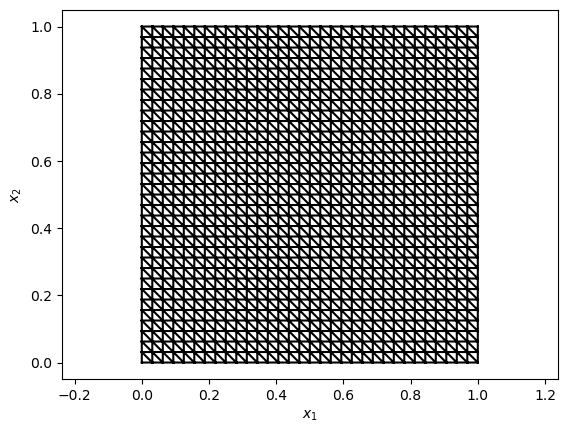

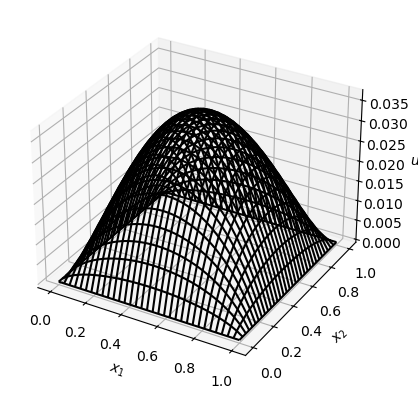

In [ ]:
def Uniform_Mesh(ns):
    n = ns + 1
    h = 1/ns
    x = np.linspace(0, 1, ns+1)
    y = np.linspace(0, 1, ns+1)
    xv, yv = np.meshgrid(x, y)
    xv = xv.ravel()
    yv = yv.ravel()
    nvtx = n**2
    nsqr = ns**2
    ne = 2*nsqr
    elt2vert = np.zeros((ne, 3), dtype='int')
    vv=np.reshape(np.arange(0, nvtx),(ns + 1,ns + 1), order='F')
    v1=vv[:-1, :-1]; v2=vv[1:, :-1]; v3=vv[:-1, 1:]; v4=vv[1:, 1:]
    elt2vert[:nsqr, :] = np.vstack((v1.ravel(), v2.ravel(), v3.ravel())).T
    elt2vert[nsqr:, :] = np.vstack((v4.ravel(), v3.ravel(), v2.ravel())).T
    plt.figsi
    plt.axis('equal')
    plt.triplot(xv.ravel(),yv.ravel(), elt2vert, 'k-')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    return h, xv, yv, elt2vert, nvtx, ne

def Get_Jacobian_Info(xv, yv, ne, elt2vert):
    Jks = np.zeros((ne, 2, 2))
    invJks = np.zeros((ne, 2, 2))
    x1=xv[elt2vert[:,0]]; x2=xv[elt2vert[:,1]]; x3=xv[elt2vert[:,2]]
    y1=yv[elt2vert[:,0]]; y2=yv[elt2vert[:,1]]; y3=yv[elt2vert[:,2]]
    Jks[:,0,0]=x2 - x1; Jks[:,0,1]=y2 - y1
    Jks[:,1,0]=x3 - x1; Jks[:,1,1]=y3 - y1
    detJks=Jks[:,0,0]*Jks[:,1,1]-Jks[:,0,1]*Jks[:,1,0]
    invJks[:,0,0]=(y3 - y1)/detJks
    invJks[:,0,1]=(y1 - y2)/detJks
    invJks[:,1,0]=(x1 - x3)/detJks
    invJks[:,1,1]=(x2 - x1)/detJks
    return Jks, invJks, detJks

def Get_Integration_Info_r1(ne, invJks, detJks, a, f):
    Ak = np.zeros((ne, 3, 3))
    bk = np.zeros((ne, 3))
    dpsi_ds=np.array([-1,1,0])
    dpsi_dt=np.array([-1,0,1])
    for i in range(3):
        for j in range(3):
            grad=np.array([[dpsi_ds[i],dpsi_ds[j]],
                           [dpsi_dt[i],dpsi_dt[j]]])       
            v1=np.dot(invJks[:,:,:], grad[:, 0])
            v2=np.dot(invJks[:,:,:], grad[:, 1])
            tmp = detJks * np.sum(v1 * v2, axis=1)
            Ak[:,i,j] = Ak[:,i,j] + a*tmp/ 2
        bk[:,i]=bk[:,i] + f*detJks / 6
    return Ak,bk

def FEM_Solver2D_r1(ns, xv, yv, elt2vert, nvtx, ne, a, f):
    Jks, invJks, detJks = Get_Jacobian_Info(xv, yv, ne, elt2vert)
    Aks, bks = Get_Integration_Info_r1(ne, invJks,detJks,a,f)
    A = sparse.csc_matrix((nvtx,nvtx))
    A = sum(sparse.csc_matrix((Aks[:,row_no,col_no], (elt2vert[:,row_no], elt2vert[:,col_no])), (nvtx,nvtx)) for row_no in range(3)  for col_no in range(3))
    b=np.zeros(nvtx)
    for row_no in range(3):
        nrow=elt2vert[:,row_no]
        b[nrow] = b[nrow]+bks[:,row_no]
    # get discrete Dirichlet boundary data 
    b_nodes = np.squeeze(np.hstack((np.where(xv == 0), np.where(xv == 1), np.where(yv == 0), np.where(yv == 1))))
    b_nodes = np.unique(b_nodes)
    int_nodes = np.ones(nvtx, dtype='bool');    
    int_nodes[b_nodes]=False;    
    b_int=np.squeeze(b[int_nodes])
    wB=g_eval(xv[b_nodes], yv[b_nodes])
    # solve linear system for interior nodes;
    Ab = A[int_nodes,:];    Ab = Ab[:,b_nodes]
    rhs=b_int - Ab.dot(wB)
    A_int=A[int_nodes,:];    A_int=A_int[:,int_nodes]
    u_int=sparse.linalg.spsolve(A_int,rhs)
    # combine with boundary data and plot
    uh=np.zeros(nvtx)
    uh[int_nodes] = u_int
    uh[b_nodes] = wB
    #
    m=ns + 1
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X = xv.reshape((m, m))
    Y = yv.reshape((m, m))
    Z = uh.reshape((m, m))
    ax.plot_wireframe(X, Y, Z, color='k')
    ax.set_zlabel(r'$u$')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')

    plt.show()
    
    return u_int,A_int,rhs
            
def g_eval(x,y):
    g=np.zeros(x.shape)
    return g      

ns = 32
h, xv, yv, elt2vert, nvtx, ne = Uniform_Mesh(ns)
u_int,A_int,rhs = FEM_Solver2D_r1(ns, xv, yv, elt2vert, nvtx, ne, np.ones(ne), np.ones(ne))

Then we consider the MCFEM.

In [53]:
print(np.arange(1,10))

[1 2 3 4 5 6 7 8 9]


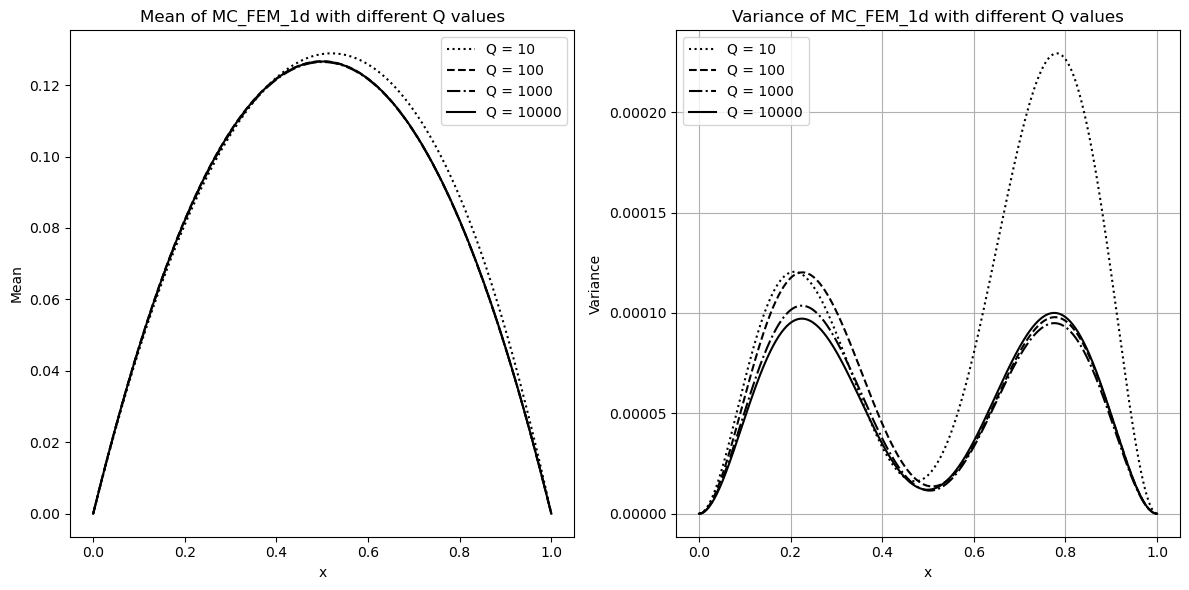

In [80]:
def MC_FEM_1d(ne, sigma, mu, P, Q):
    '''P for the diffusion coefficients and Q the samples number'''
    h = 1 / ne
    nvtx = ne + 1
    x = np.arange(h/2, 1, h)
    mean = 0
    var = 0
    for i in range(Q):
        xi = np.random.uniform(-1, 1, ne)
        a = mu * np.ones(ne)
        for k in range(1, P+1):
            a = a + sigma * (k * pi)**(-2) * np.cos(x * k * pi) * xi[k]
        uh, A, b, K, M = FEM_Solver1D_r1(ne, a, np.zeros(ne), np.ones(ne))
        mean = mean + uh
        var = var + uh**2
    mean = mean / Q
    var = (var - mean**2 * Q)/ (Q - 1)
    return mean, var

ne = 512
x = np.linspace(0, 1, ne + 1)
Q_values = [10, 100, 1000, 10000]
linestyles = ['dotted', 'dashed', 'dashdot', 'solid']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for Q, linestyle in zip(Q_values, linestyles):
    mean, var = MC_FEM_1d(ne, 4, 1, 10, Q)
    ax1.plot(x, mean, linestyle=linestyle, color='k', label=f'Q = {Q}')
    ax2.plot(x, var, linestyle=linestyle, color='k', label=f'Q = {Q}')

ax1.set_title('Mean of MC_FEM_1d with different Q values')
ax1.set_xlabel('x')
ax1.set_ylabel('Mean')
ax1.legend()

ax2.set_title('Variance of MC_FEM_1d with different Q values')
ax2.set_xlabel('x')
ax2.set_ylabel('Variance')
ax2.legend()

plt.grid(True)
plt.tight_layout()
plt.show()